In [34]:
import os
import sys
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk, plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss, l1_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('highest')
device = torch.device("cuda") if torch.cuda.is_available() else "mps"
print(device)
import importlib
import unet_parts
import unet_model
import utils

importlib.reload(utils) 
importlib.reload(unet_parts) 
from utils import draw_figure
from unet_parts import *

importlib.reload(unet_model) 
from unet_model import UNetFiLM, ResNetFiLM

cuda


In [3]:
seed_everything(7, workers=True)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4

[rank: 0] Seed set to 7


In [18]:
class trainCNN(LightningModule):
    def __init__(
        self,
        model,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-2,
        n_sampling_steps: int = 250, 
        fourier_upweight_range=(3, 15), 
        fourier_weight=1e-5,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        self.fourier_upweight_range = fourier_upweight_range
        self.fourier_weight = fourier_weight
        
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, cdm_map, params) -> Tensor:
        cdm_map = cdm_map
        params = params
        return self.model(cdm_map,params)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map,params,true_map = batch
        cdm_map = cdm_map.to(device)
        params = params.to(device)
        true_map = true_map.to(device)
        mtot_pred = self(cdm_map,params).to(device)
        fourier_loss = self.fourier_loss(mtot_pred, true_map)
        # Log the individual loss components
        self.log("fourier_loss", fourier_loss, on_epoch=True, prog_bar=True)
        loss = l1_loss(mtot_pred, true_map)
        self.log("l1_loss", loss, on_epoch=True, prog_bar=True)
        #if self.current_epoch >= 2:
            #loss += fourier_loss
        return fourier_loss

    def get_current_max_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[1]
            
        progress = self.current_epoch / self.trainer.max_epochs
        max_freq = self.fourier_upweight_range[1]
    
        if progress < 0.33:
            return max_freq / 3
        elif progress < 0.66:
            return (max_freq * 2) / 3
        else:
            return max_freq

    def get_current_min_freq(self):
        """Calculate current maximum frequency based on training progress"""
        if self.trainer is None:
            return self.fourier_upweight_range[0]
            
        progress = self.current_epoch / self.trainer.max_epochs
        min_freq = self.fourier_upweight_range[0]
    
        if progress < 0.33:
            return 0.5
        elif progress < 0.66:
            return (min_freq * 2) / 3
        else:
            return min_freq
       
    
    def fourier_loss(self, output, target):

        output_fft = torch.fft.fft2(output)
        target_fft = torch.fft.fft2(target)
    
        _, _, H, W = output.shape
        L = 25. #Mpc/c

        kx = torch.fft.fftfreq(H, d=1. / (H * 2 * np.pi / L)).to(output.device)
        ky = torch.fft.fftfreq(W, d=1. / (W * 2 * np.pi / L)).to(output.device)
        kx, ky = torch.meshgrid(kx, ky, indexing="ij") #[256, 256],[256, 256]
        k = torch.sqrt(kx**2 + ky**2) 
        
        high = self.fourier_upweight_range[1] #self.get_current_max_freq() #
        low = self.fourier_upweight_range[0] # self.get_current_min_freq() #
        order = 2 
        low_pass = 1 / (1 + (k / high)**(2 * order))
        high_pass = 1 / (1 + (low / k)**(2 * order))
        weight_mask = self.fourier_weight*low_pass 
        #weight_mask = self.fourier_weight*low_pass*high_pass #change to Butterworth filter
        
        #weight_mask = torch.zeros_like(k)
        #weight_mask[(k >= low) & (k <= high)] = self.fourier_weight # Double weight in the range
    
        # Expand the mask for all batches and channels
        weight_mask = weight_mask[None, None, :, :].to(output.device)
        loss = torch.mean(weight_mask * (output_fft - target_fft).real ** 2) + torch.mean(weight_mask * (output_fft - target_fft).imag ** 2) #r_cc is phase not mag

        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        loss = self.evaluate(batch, "train")
        self.log("train_loss", loss, on_epoch=True)
        #log_loss = torch.log(loss)
        return loss #log_loss


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning,params,x = batch 
        loss = self.evaluate(batch)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model = 'ResNet')
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, params, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning,params)
            fig = self.draw_figure(x,sample,conditioning,self.dataset,model='ResNet')
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10, # ~ num_steps // 3
            eta_min=3e-5,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        cdm_map,params,true_map = batch
        return self(cdm_map,params)

In [40]:

from unet_model import UNetFiLM,ResNetFiLM
cnn = trainCNN(
        model =ResNetFiLM(1,1,use_fourier_features=False,high_pass=False), #.to(device) #SimpleNet() #ResnetGenerator(1,1) #SimpleNet()
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    ).to(device)

    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, # 50 6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="Nbody_Hydro",
            experiment_name='ResNet_Film_no_init_PixelShuffle_upsample_epoch10_Fourier_ONLY_weight_1e5_15_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody',
            offline=False,
            save_dir='/pscratch/sd/l/lindajin/LOGS/'
            #'Unet_TF_fft' too slow
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #10 1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint]
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [28]:
dm_25_thick_mtot = get_astro_data(
        dataset,
        25,
        num_workers=num_workers,
        batch_size=batch_size,
    )

In [41]:
trainer.fit(model=cnn, datamodule=dm_25_thick_mtot) 

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/c8afe6bd4e4b4e698ecfff308c0cea0d

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | ResNetFiLM | 21.9 M | train
---------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.748    Total estimated model params size (MB)
124       Modules in train mode
0         Modules in eval mode
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64,

CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot?it/s]



CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHN

Epoch 0, global step 175: 'val_loss' reached 2.45696 (best 2.45696), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=0-step=175.ckpt' as top 1


CHNG: m_totCHNG: m_totCHNG: m_tot00:00<?, ?it/s, v_num=ea0d, fourier_loss_step=2.210, l1_loss_step=0.535, fourier_loss=2.460, l1_loss=0.590, val_loss=2.460, fourier_loss_epoch=2.470, l1_loss_epoch=0.571]          


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot

CHNG: m_totCHNG:

Epoch 1, global step 350: 'val_loss' reached 2.16696 (best 2.16696), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=1-step=350.ckpt' as top 1


CHNG: m_tot0%|          | 0/175 [00:00<?, ?it/s, v_num=ea0d, fourier_loss_step=1.820, l1_loss_step=0.522, fourier_loss=2.170, l1_loss=0.529, val_loss=2.170, fourier_loss_epoch=2.240, l1_loss_epoch=0.543]          
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_

Epoch 2, global step 525: 'val_loss' reached 2.14758 (best 2.14758), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=2-step=525.ckpt' as top 1


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tott/s, v_num=ea0d, fourier_loss_step=2.080, l1_loss_step=0.529, fourier_loss=2.150, l1_loss=0.526, val_loss=2.150, fourier_loss_epoch=2.200, l1_loss_epoch=0.535]          



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHN

Epoch 3, global step 700: 'val_loss' reached 2.10685 (best 2.10685), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=3-step=700.ckpt' as top 1


CHNG: m_tot0%|          | 0/175 [00:00<?, ?it/s, v_num=ea0d, fourier_loss_step=1.800, l1_loss_step=0.534, fourier_loss=2.110, l1_loss=0.525, val_loss=2.110, fourier_loss_epoch=2.210, l1_loss_epoch=0.539]          
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot


CHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_

Epoch 4, global step 875: 'val_loss' was not in top 1


CHNG: m_totCHNG: m_totCHNG: m_tot00:00<?, ?it/s, v_num=ea0d, fourier_loss_step=1.970, l1_loss_step=0.525, fourier_loss=2.160, l1_loss=0.615, val_loss=2.160, fourier_loss_epoch=2.180, l1_loss_epoch=0.535]          

CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG

Epoch 5, global step 1050: 'val_loss' was not in top 1


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tott/s, v_num=ea0d, fourier_loss_step=2.500, l1_loss_step=0.551, fourier_loss=2.120, l1_loss=0.536, val_loss=2.120, fourier_loss_epoch=2.180, l1_loss_epoch=0.532]          



CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHN

Epoch 6, global step 1225: 'val_loss' was not in top 1


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_totea0d, fourier_loss_step=2.450, l1_loss_step=0.514, fourier_loss=2.140, l1_loss=0.520, val_loss=2.140, fourier_loss_epoch=2.160, l1_loss_epoch=0.531]          
CHNG: m_tot




CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot


CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot

CHN

Epoch 7, global step 1400: 'val_loss' was not in top 1


CHNG: m_totCHNG: m_tot  | 0/175 [00:00<?, ?it/s, v_num=ea0d, fourier_loss_step=2.350, l1_loss_step=0.542, fourier_loss=2.110, l1_loss=0.527, val_loss=2.110, fourier_loss_epoch=2.150, l1_loss_epoch=0.531]          

CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_t

Epoch 8, global step 1575: 'val_loss' reached 2.10518 (best 2.10518), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=8-step=1575.ckpt' as top 1


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tott/s, v_num=ea0d, fourier_loss_step=2.180, l1_loss_step=0.523, fourier_loss=2.110, l1_loss=0.572, val_loss=2.110, fourier_loss_epoch=2.140, l1_loss_epoch=0.527]          



CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG

Epoch 9, global step 1750: 'val_loss' reached 2.08568 (best 2.08568), saving model to '/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/best_model-epoch=9-step=1750.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 175/175 [00:30<00:00,  5.67it/s, v_num=ea0d, fourier_loss_step=2.240, l1_loss_step=0.513, fourier_loss=2.090, l1_loss=0.527, val_loss=2.090, fourier_loss_epoch=2.130, l1_loss_epoch=0.529]


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_Film_no_init_PixelShuffle_upsample_epoch10_Fourier_ONLY_weight_1e5_15_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/c8afe6bd4e4b4e698ecfff308c0cea0d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss [10]       : (2.0856759548187256, 2.4569616317749023)
COMET INFO:     fourier_loss_epoch [10] : (2.134010076522827, 2.469512701034546)
COMET INFO:     fourier_loss_step [35]  : (1.4018833637237549, 3.104372024536133)
COMET INFO:     l1_loss [10]            : (0.5203229188919067, 0.6147459745407104)
COMET INFO:     l1_loss_epoch [10]      : (0.52

In [43]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/latest-epoch=9-step=1750.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/c8afe6bd4e4b4e698ecfff308c0cea0d

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/LOGS/Nbody_Hydro/c8afe6bd4e4b4e698ecfff308c0cea0d/checkpoints/latest-epoch=9-step=1750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
COMET WARNING: String value length exceeds 1000 characters and will be truncated. Provided value: 'ResNetFiLM(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot




CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_totCHNG: m_tot



CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot


CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot
CHNG: m_tot

CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot

CHNG: m_totCHNG: m_totCHNG: m_tot


CHNG: m_tot
CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_totCHNG: m_tot

CHNG: m_tot
CHNG: m_tot

CHNG: m_tot
CHNG: m_totCHNG: m_tot
CHNG: m_tot
CHNG:

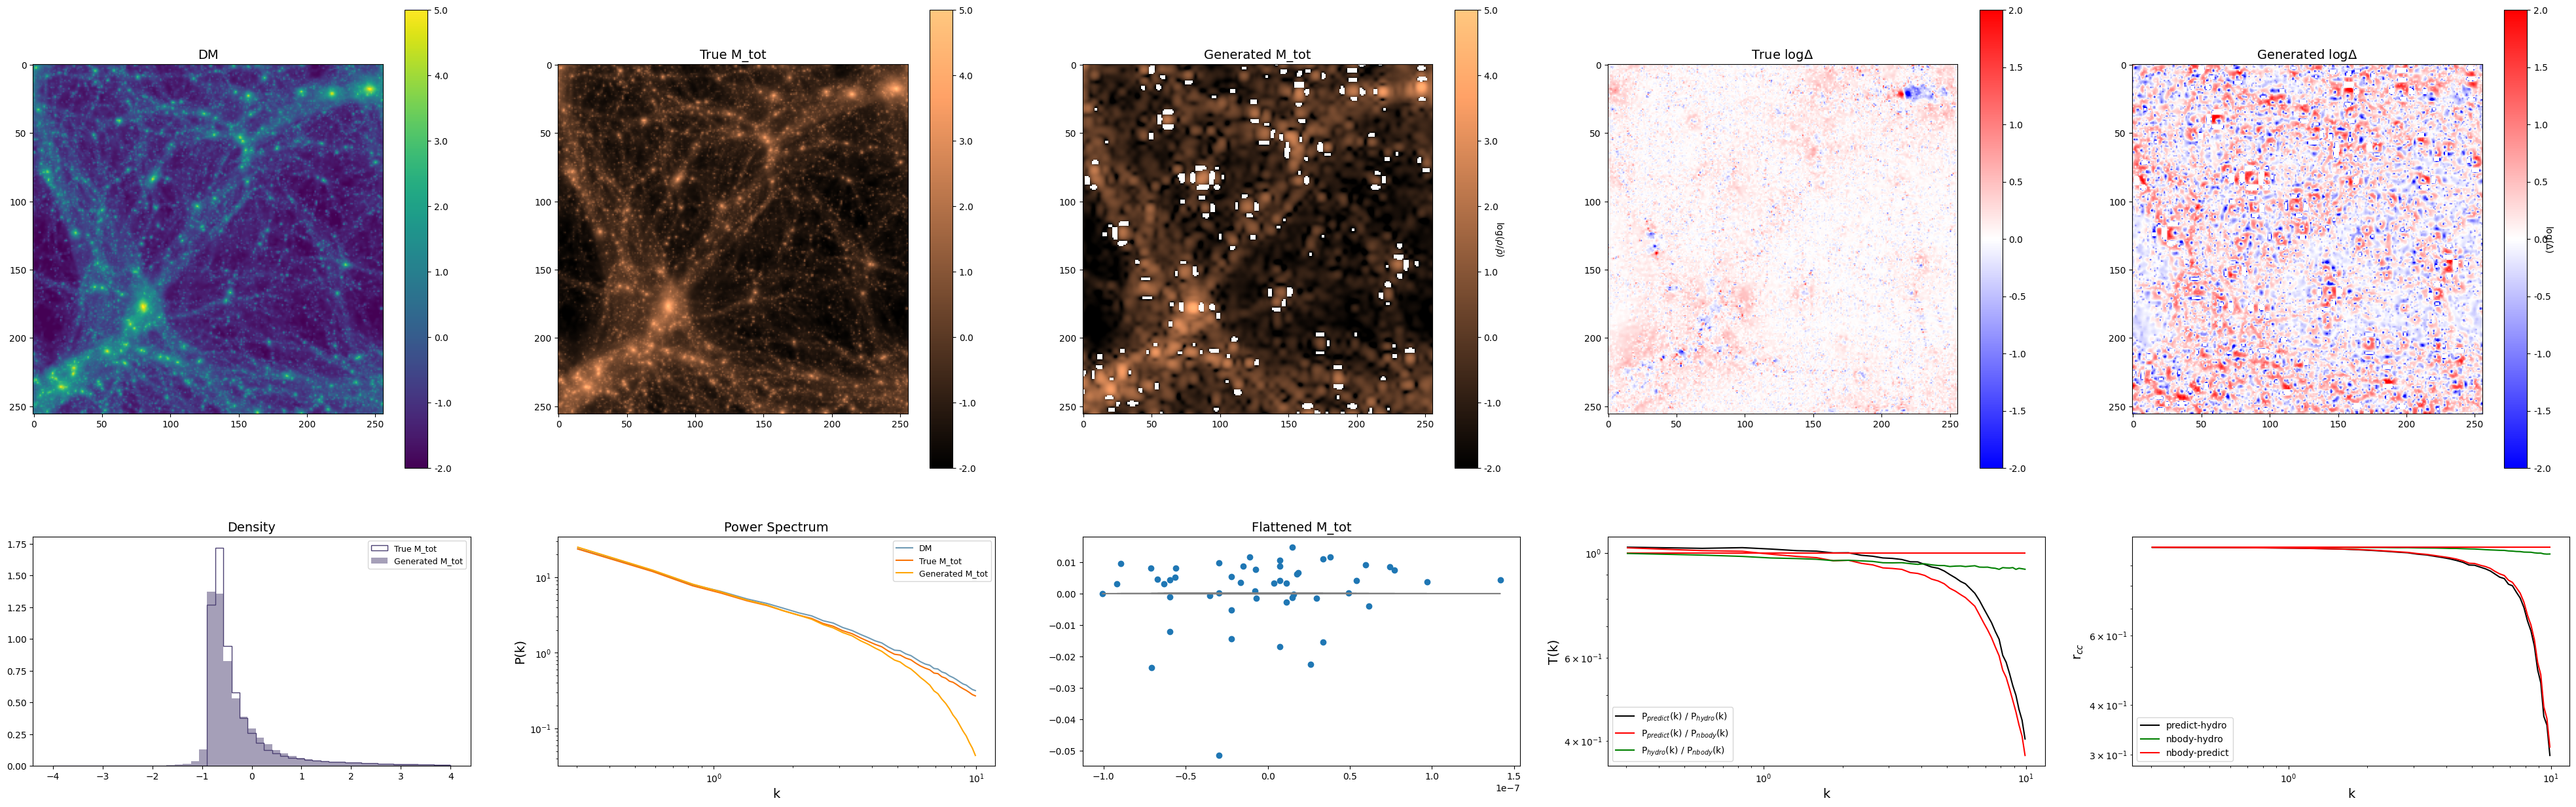

no high pass
Testing DataLoader 0: 100%|██████████| 6/6 [00:09<00:00,  0.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       fourier_loss        │    2.1398468017578125     │
│          l1_loss          │    0.5313770174980164     │
│         test_loss         │            0.0            │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_Film_no_init_PixelShuffle_upsample_epoch10_Fourier_ONLY_weight_1e5_15_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/c8afe6bd4e4b4e698ecfff308c0cea0d
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     fourier_loss  : 2.1398468017578125
COMET INFO:     l1_loss       : 0.5313770174980164
COMET INFO:     test_loss [2] : (0.0, 2.0487473011016846)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : ResNet_Film_no_init_PixelShuffle_upsample_epoch10_Fourier_ONLY_weight_1e5_15_Butterworth_lr_1e3_adamw_1e2_

In [44]:
test_loss = trainer.test(model=None, datamodule=dm_25_thick_mtot, ckpt_path = path)

In [39]:
comet_logger.experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/nbody-hydro/5acf52c103064e2698ab0e3f5c01bb48

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : ResNet_Film_no_init_bicubic_upsample_epoch10_Fourier_ONLY_weight_1e5_15_Butterworth_lr_1e3_adamw_1e2_25_thickness_Nbody
COMET INFO:     url                   : https://www.comet.com/klinjin/nbody-hydro/5acf52c103064e2698ab0e3f5c01bb48
COMET INFO:   Ot